## Pertubation of the apex edge-sampled domains

# Imports

In [1]:
import copy
import os
import random
import sys
print(sys.executable)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as sp
from scipy import spatial, sparse

import torch
import torch_scatter
#from torch_scatter import scatter
import torch_geometric.transforms as T


from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

from numba import njit

# Project-specific imports
from src import utils
from src.loader import load_graph
from src.utils import (largest_indices, cal_n_add_facni, 
                       extract_feat_adj2, calc_cad)
from classes import extract_all_features_single


/home/sucharitha/MintA/venv_minta/bin/python


# Routines

In [2]:
def confid_measures(arr_tri, Num):
    # Ensure arr_tri is at least 2D for consistent handling
    arr_tri = np.atleast_2d(arr_tri)
    arr_tri_mean=np.mean(arr_tri, axis=0)
    std=np.std(arr_tri, axis=0)
    Z=1.960 # for 95 conf.
    upper=arr_tri_mean+Z*std/np.sqrt(Num)
    lower=arr_tri_mean-Z*std/np.sqrt(Num)
    
    # Debugging shapes (optional, for troubleshooting)
    print("Shape of arr_tri:", arr_tri.shape)
    print("Shape of arr_tri_mean:", arr_tri_mean.shape)
    print("Sorted mean:", np.sort(arr_tri_mean))
    print("Sorted lower:", np.sort(lower))
    print("Sorted upper:", np.sort(upper))

    
    #return arr_tri_mean, lower, upper
    return np.sort(arr_tri_mean), np.sort(lower), np.sort(upper)

def find_my_soln(WW):
    ATA=np.dot(WW,WW.T)
    w, v=np.linalg.eig(ATA)
    return v[:,0]

def flip_the_bins(x,lox):
    m=np.zeros_like(x)
    m[:,lox]=1
    x_bol=np.array(x, dtype=bool);
    m_bol=np.array(m, dtype=bool);
#     x2=np.logical_or(x_bol,m_bol)
    x2=np.logical_xor(x_bol,m_bol)
    x2=x2.astype(float)
    x2=torch.from_numpy(x2)
    return x2

def preds_of_adv(model0, data, adv_nodes_test):
    with torch.no_grad():
        model0.eval()
    pred_raw0 = model0(data.x_dict, data.edge_index_dict)
    y0_hat= pred_raw0.argmax(dim=-1)
    preds=y0_hat[adv_nodes_test]
    return preds

def my_own_acc(a, b):
    acc = np.sum(np.equal(a, b)) / len(a)
    return acc

def my_score(pred, labels):
    accuracy = (pred == labels).sum() / len(pred)
    return accuracy

def model_qurey(model, data, idx_train):
    model.eval()
    pred_raw2 = model(data.x_dict, data.edge_index_dict)
    pred_raw2 = F.softmax(pred_raw2, dim=1)
    y2_hat= pred_raw2.argmax(dim=-1)
    labels_sur=y2_hat[idx_train]    
    return labels_sur

def randbin(M,N,P):  
    return np.random.choice([0, 1], size=(M,N), p=[P, 1-P])

def do_perturb_feat(x,m):
    x_bol=np.array(x, dtype=bool);
    m_bol=np.array(m, dtype=bool);
    x2=np.logical_xor(x_bol,m_bol)
    x2=x2.astype(float)
    x2=torch.from_numpy(x2)
    return x2

def do_perturb_adj(a,m):
    a_bol=np.array(a, dtype=bool);
    m_bol=np.array(m, dtype=bool);
    a2=np.logical_xor(a_bol,m_bol)
    a2=a2.astype(float)
    a2=torch.from_numpy(a2)
    return a2

def A_to_edge_index(A):
    
    adj_t = torch.tensor(A) 
    edge_index = adj_t.nonzero().t().contiguous()
    return edge_index

def get_As_new(adj_1,adj_2,adj_3,adj_4,relation):

    domain_node_list=np.concatenate((adj_1.cpu()[0], adj_2.cpu()[0], adj_3.cpu()[0], adj_4.cpu()[0]), axis=0)
    domain_node_list=np.unique(domain_node_list)
    test_mask = data['domain_node']['test_mask']
    xx_test=np.where(test_mask.cpu()>0) 
    domain_node_list_test=domain_node_list[xx_test]
    # print(len(domain_node_list_test))
    elist_test = []
    aaa=np.array(adj_2.cpu())
    for x in range(adj_2.shape[1]):
        innerlist = ((aaa[0,x], aaa[1,x]))
        if aaa[0,x] in domain_node_list_test:
            elist_test.append(innerlist)

    Atest=np.zeros( (len(domain_node_list_test),len(domain_node_list_test)), dtype=int)
    for k in range(len(elist_test)):
        a=elist_test[k][0]
        b=elist_test[k][1]
        lox_a=np.where(domain_node_list_test == a)
        lox_b=np.where(domain_node_list_test == b)
        Atest[lox_a,lox_b]=1
    
    return Atest

def edge_list_to_adj(adv_edge_list):
    elist=adv_edge_list.cpu()
    domain_node_list=np.unique(elist[0,:])
    A=np.zeros( (len(domain_node_list),len(domain_node_list)), dtype=int)
    for k in range(len(elist)):
        a=elist[k][0]
        b=elist[k][1]
        lox_a=np.where(domain_node_list == a)
        lox_b=np.where(domain_node_list == b)
        A[lox_a,lox_b]=1
    return A

def extract_A(data, adv_nodes):
    edge_list_1=data.edge_index_dict['domain_node', 'apex', 'domain_node'][0,:]
    edge_list=data.edge_index_dict['domain_node', 'apex', 'domain_node']
#     adv_nodes=np.array([0,1,4,5,6])
    common_node_lox=np.nonzero(np.in1d(edge_list_1.cpu(), adv_nodes))[0]
    adv_edge_list=edge_list[:,common_node_lox]
#     print(adv_edge_list)
    A_adv=edge_list_to_adj(adv_edge_list.cpu())
    return A_adv

def edge_list_to_adj(adv_edge_lox1, adv_edge_lox2):
    elist=adv_edge_lox2
    print(elist)
    domain_node_list=np.unique(elist)
    domain_node_list=domain_node_list[0:4000]
    A=np.zeros( (len(domain_node_list),len(domain_node_list)), dtype=int)
    for k in range(len(elist)):
        a=adv_edge_lox1[k]
        b=adv_edge_lox2[k]
        lox_a=np.where(domain_node_list == a)
        lox_b=np.where(domain_node_list == b)
        A[lox_a,lox_b]=1
    return A

def extract_As_jan(data, adv_nodes):
    edge_list=data.edge_index_dict['domain_node', 'apex', 'domain_node']
    all_edges1=edge_list[0,:]
    all_edges2=edge_list[1,:]
    
    all_edges1=all_edges1.cpu()
    all_edges2=all_edges2.cpu()

    adv_edge_lox1= np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2= np.nonzero(np.in1d(all_edges2, adv_nodes))[0]
    L=len(adv_nodes)
    A_adv1=np.zeros( (L,L), dtype=int)
    adv_nodes=np.array(adv_nodes)
    adv_edge_lox1=np.array(adv_edge_lox1)
    adv_edge_lox2=np.array(adv_edge_lox2)

    for k in range(adv_edge_lox1.shape[0]):
        a=all_edges1[adv_edge_lox1[k]]
        b=all_edges2[adv_edge_lox2[k]]
        lox_a=np.where(adv_nodes == np.array(a))
        lox_b=np.where(adv_nodes == np.array(b))
#         print(lox_a, lox_b)
        A_adv1[lox_a,lox_b]=1
        
    print("sparsity", np.count_nonzero(A_adv1))    
     
    edge_list=data.edge_index_dict['domain_node', 'similar', 'domain_node']
    all_edges1=edge_list[0,:]
    all_edges2=edge_list[1,:]
    
    all_edges1=all_edges1.cpu()
    all_edges2=all_edges2.cpu()

    adv_edge_lox1= np.nonzero(np.in1d(all_edges1, adv_nodes))[0]
    adv_edge_lox2= np.nonzero(np.in1d(all_edges2, adv_nodes))[0]

    L=len(adv_nodes)
    A_adv2=np.zeros( (L,L), dtype=int)
    adv_nodes=np.array(adv_nodes)
    adv_edge_lox1=np.array(adv_edge_lox1)
    adv_edge_lox2=np.array(adv_edge_lox2)

    for k in range(adv_edge_lox1.shape[0]):
        a=all_edges1[adv_edge_lox1[k]]
        b=all_edges2[adv_edge_lox2[k]]
        lox_a=np.where(adv_nodes == np.array(a))
        lox_b=np.where(adv_nodes == np.array(b))
        A_adv2[lox_a,lox_b]=1
        
    print("sparsity", np.count_nonzero(A_adv2)) 
    
    
    A_adv=A_adv1+A_adv2
    
    return A_adv

def calc_ASR(data, adv_nodes_test, model0):
    
    with torch.no_grad():
        model0.eval()
        pred_raw0 = model0(data.x_dict, data.edge_index_dict)
        pred_raw0 = F.softmax(pred_raw0, dim=1)
        y0_hat= pred_raw0.argmax(dim=-1)
        
    y0_hat=y0_hat[adv_nodes_test]    

    with torch.no_grad():
        model0.eval()
        pred_raw2 = model0(data.x_dict2, data.edge_index_dict2)
        pred_raw2 = F.softmax(pred_raw2, dim=1)
        y2_hat= pred_raw2.argmax(dim=-1)
    y2_hat=y2_hat[adv_nodes_test]        

    num_of_1=0;
    num_of_1_forced_to_0=0;
    num_of_0=0;
    num_of_0_forced_to_1=0;
    
    for jj in range(len(y0_hat)):
        if y0_hat[jj]==1:
            num_of_1=num_of_1+1
        if y0_hat[jj]==1 and y2_hat[jj]==0:
            num_of_1_forced_to_0=num_of_1_forced_to_0+1;
            
        if y0_hat[jj]==0:
            num_of_0=num_of_0+1
        if y0_hat[jj]==0 and y2_hat[jj]==1:
            num_of_0_forced_to_1=num_of_0_forced_to_1+1;
            
    if num_of_1>0:
        ASRgood=num_of_1_forced_to_0/num_of_1
    else:
        ASRgood=num_of_1_forced_to_0

        
    if num_of_0>0:
        ASRbad=num_of_0_forced_to_1/num_of_0
    else:
        ASRbad=num_of_0_forced_to_1

    print("ASRgood", ASRgood, num_of_1_forced_to_0, num_of_1, "ASRbad", ASRbad, num_of_0_forced_to_1, num_of_0)
    return ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0

def assign_Adversary_nas_mal(data, norm_zero_int):
    test_mask = data['domain_node']['test_mask']
    labels_test=data['domain_node'].y[test_mask].cpu()
    lox_test=np.where(test_mask.cpu()>0)
    lox_test=lox_test[0]
    labels=data['domain_node'].y.cpu()
    lox_test_space=lox_test[np.where(labels_test.cpu()==1) ] #mal
    adv_nodes_test=random.sample(set(lox_test_space), norm_zero_int)   
    return adv_nodes_test

def assign_Adversary_ras(data, norm_zero_int):
    test_mask = data['domain_node']['test_mask']
    labels_test=data['domain_node'].y[test_mask].cpu()
    lox_test=np.where(test_mask.cpu()>0)
    lox_test=lox_test[0]
    labels=data['domain_node'].y.cpu()
    lox_test_space=lox_test[np.where(labels_test.cpu()==1) ] #mal
    adv_nodes_test=random.sample(set(lox_test_space), norm_zero_int)
    return adv_nodes_test


# Load datasets

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
from src.loader2 import DNS2
kg_path = lambda graph_name: f'/home/sucharitha/MintA/myGraph_datasets/{graph_name}'
dataset = DNS2('myGraph_datasets/DNS', transform=T.Compose([T.NormalizeFeatures(), T.ToUndirected()]), balance_gt=True)
data = dataset[0]
# dir(data)
#feats_2=cal_n_add_facni(kg_path('DNS'), data);
#torch.save(feats_2, 'feats_2.pt')
# This script is for eature extraction
# import warnings
# warnings.filterwarnings('ignore')
# dir(data)
#feats_new2=cal_n_add_facni(kg_path('DNS'), data);
#torch.save(feats_new2, 'feats_new2.pt')

# Feature assignment 
feats_new2=torch.load('feats_new2.pt')
data['domain_node'].x= feats_new2[0:data.x_dict['domain_node'].shape[0],:]
data['ip_node'].x=torch.zeros(data['ip_node'].x.shape[0],1)
data['host_node'].x=torch.zeros(data['host_node'].x.shape[0],1)
del feats_new2
print(os.getcwd())

# print(data.metadata)

/home/sucharitha/MintA


# The MDD model 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import TransformerConv, Linear

class GraphTransformerNetwork(nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers=3, num_heads=8, dropout=0.05):
        super().__init__()

        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(
                TransformerConv(
                    in_channels=(-1, -1),  # Automatically infer input feature dimensions
                    out_channels=hidden_channels,
                    heads=num_heads,
                    dropout=dropout
                )
            )
        self.fc = nn.Linear(hidden_channels * num_heads, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x = x_dict['domain_node']  # Input features for domain nodes
        edge_index = edge_index_dict[('domain_node', 'apex', 'domain_node')]  # Edge type

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        return self.fc(x)

# Initialize the GTN model
model = GraphTransformerNetwork(
    metadata=data.metadata(),  # Metadata for heterogeneous graph
    hidden_channels=64,        # Hidden feature size
    out_channels=2,            # Number of output classes (binary classification)
    num_layers=2               # Number of transformer layers
)


In [5]:
print(torch.cuda.device_count())  # Check for available CUDA devices

# Set CUDA device and move data and model to the GPU
torch.cuda.set_device(0)  # Use the first GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = model.to(device)

# Initialize lazy modules by running a forward pass
with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)

# Define optimizer with Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

# Training function
def train(model, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)  # Forward pass
    mask = data['domain_node'].train_mask
    loss = F.cross_entropy(out[mask], data['domain_node'].y[mask])  # Cross-entropy loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    return float(loss)

# Testing function
@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)  # Predicted classes
    accs = []  # Store accuracy for train, validation, and test
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['domain_node'][split]
        acc = (pred[mask] == data['domain_node'].y[mask]).sum() / mask.sum()  # Accuracy
        accs.append(float(acc))
    return accs


1


# The surrogate

In [6]:
from torch_geometric.nn import TransformerConv
from torch_geometric.utils import dense_to_sparse  # To convert dense adjacency matrix to edge index
import torch.nn.functional as F
import numpy as np
import torch

# Extract data to train the surrogate model
train_mask = data['domain_node'].train_mask
labels_train = data['domain_node'].y.cpu()
labelled_labels_train_lox = np.where(labels_train < 2)
lox_train = np.where(train_mask.cpu() > 0)
lox_train = lox_train[0]

# Select training nodes and their features
labels = data['domain_node'].y.cpu()
lox_train_space = labelled_labels_train_lox
adv_nodes_train = lox_train_space[0][0:4000]  # Use the first 4000 nodes for training
Adj_sur = extract_As_jan(data, adv_nodes_train)  # Adjacency matrix for surrogate
features_sur = data['domain_node'].x[adv_nodes_train]

# Convert features_sur to a PyTorch tensor if necessary
if isinstance(features_sur, np.ndarray):  # If it's a NumPy array, convert to tensor
    features_sur = torch.tensor(features_sur, dtype=torch.float32)
else:  # If it's already a tensor, ensure correct type
    features_sur = features_sur.float()

data.x_sur = features_sur  # Store features for surrogate training
idx_train = np.arange(4000)  # Training indices

# Ensure Adj_sur is a PyTorch tensor
if isinstance(Adj_sur, np.ndarray):  # If it's a NumPy array, convert to tensor
    Adj_sur = torch.tensor(Adj_sur, dtype=torch.float32)
else:  # If it's already a tensor, ensure correct type
    Adj_sur = Adj_sur.float()

# Convert dense adjacency matrix (Adj_sur) to edge index format
edge_index_sur, _ = dense_to_sparse(Adj_sur)  # Convert to edge index format
edge_index_sur = edge_index_sur.to(torch.int64)  # Ensure integer type for edge index

# Define the Graph Transformer Network for surrogate model
class SurrogateGTN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_layers=2, num_heads=4, dropout=0.1):
        super(SurrogateGTN, self).__init__()
        self.layers = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(
                TransformerConv(
                    in_channels=(-1, -1),  # Infer input features
                    out_channels=hidden_features,
                    heads=num_heads,
                    dropout=dropout
                )
            )
        self.fc = torch.nn.Linear(hidden_features * num_heads, out_features)

    def forward(self, x, edge_index):
        for layer in self.layers:
            x = layer(x, edge_index)
            x = F.relu(x)
        return self.fc(x)

# Initialize the surrogate model
surrogate_model = SurrogateGTN(
    in_features=features_sur.shape[1],
    hidden_features=64,  # Hidden layer size
    out_features=2,  # Binary classification
    num_layers=2,  # Number of transformer layers
    num_heads=4,
    dropout=0.1
).to(device)

# Prepare data for the surrogate model
x_sur = features_sur.to(device)  # Move features to the correct device


sparsity 3802
sparsity 2322


# The proposed MinstA

In [7]:
from torch_geometric.utils import dense_to_sparse

def one_trial():   
    # Initialize dataset and features
    dataset = DNS2('myGraph_datasets/DNS', transform=T.Compose([T.NormalizeFeatures(), T.ToUndirected()]), balance_gt=True)
    data = dataset[0]
    feats_new = torch.load('feats_new2.pt')
    data['domain_node'].x = feats_new[0:data.x_dict['domain_node'].shape[0], :]
    data['ip_node'].x = torch.zeros(data['ip_node'].x.shape[0], 1)
    data['host_node'].x = torch.zeros(data['host_node'].x.shape[0], 1)
    del feats_new

    # Extract adjacency matrices
    feat_node, feat_ip, adj_1, adj_2, adj_3, adj_4, adj_5, adj_6 = extract_feat_adj2(data)
    relation = 2
    Atest = get_As_new(adj_1, adj_2, adj_3, adj_4, relation)

    x = data['domain_node'].x.cpu()

    # Ensure valid sampling for adversarial nodes
    num_available_nodes = data['domain_node'].x.shape[0]
    num_to_sample = min(100, num_available_nodes)
    adv_nodes_test = assign_Adversary_ras(data, num_to_sample)
    A_adv = extract_As_jan(data, adv_nodes_test)

    perf_arr = np.empty((6, 0))
    val_nodes = np.array([1, 10, 30, 60, 90, 120])

    # Initialize and train a new clean model using Graph Transformer Network
    model0 = GraphTransformerNetwork(
        metadata=data.metadata(),
        hidden_channels=128,  # Increased hidden channels
        out_channels=2,
        num_layers=3,  # Increased layers
        num_heads=8,  # Increased attention heads
        dropout=0.05  # Reduced dropout
    )
    data, model0 = data.to(device), model0.to(device)
    data.x_dict2 = copy.deepcopy(data.x_dict)
    data.edge_index_dict2 = copy.deepcopy(data.edge_index_dict)

    for epoch in range(301):
        loss = train(model0, data)

    labels_sur = model_qurey(model0, data, idx_train)
    labels_sur = np.array(labels_sur.cpu())

    preds = preds_of_adv(model0, data, adv_nodes_test)

    # Ensure valid sampling for training nodes
    num_available_train_nodes = len(np.where(data['domain_node'].y.cpu() < 2)[0])
    num_train_to_sample = min(4000, num_available_train_nodes)
    adv_nodes_train = np.random.choice(num_available_train_nodes, num_train_to_sample, replace=False)

    features_sur = data['domain_node'].x[adv_nodes_train]
    features_sur = torch.tensor(features_sur.cpu().numpy(), dtype=torch.float32).to(device)

    # Ensure Adj_sur is converted to edge index
    Adj_sur = extract_As_jan(data, adv_nodes_train)
    edge_index_sur, _ = dense_to_sparse(torch.tensor(Adj_sur, dtype=torch.float32).to(device))
    edge_index_sur = edge_index_sur.to(torch.int64)

    # Initialize and train a new surrogate using GTN
    surrogate = SurrogateGTN(
        in_features=features_sur.shape[1], 
        hidden_features=64, 
        out_features=2, 
        num_layers=2, 
        num_heads=4, 
        dropout=0.1
    ).to(device)

    optimizer_surrogate = torch.optim.Adam(surrogate.parameters(), lr=0.005, weight_decay=5e-4) 
    loss_fn = nn.CrossEntropyLoss()

    surrogate.train()
    for epoch in range(100):  # Adjust epochs if needed
        optimizer_surrogate.zero_grad()
        out_surrogate = surrogate(features_sur, edge_index_sur)  # Forward pass with corrected edge_index
        loss = loss_fn(out_surrogate[idx_train], torch.tensor(labels_sur[idx_train], dtype=torch.long).to(device))  # Compute loss
        loss.backward()  # Backpropagation
        optimizer_surrogate.step()  # Update weights

    # Perturbation and ASR calculation
    for val in val_nodes: 
        print(val)
        temp0 = data.edge_index_dict2[('domain_node', 'apex', 'domain_node')]
        temp0 = np.array(temp0.cpu())
        node_list0 = temp0[0, :]
        X = x[adv_nodes_test, :].cpu()
        X = torch.tensor(np.array(X), dtype=torch.float32).to(device)  # Ensure tensor
        A = torch.tensor(np.array(A_adv), dtype=torch.float32).to(device)  # Ensure tensor
        X2 = copy.deepcopy(X)
        all_lox = np.arange(45)
        w1 = surrogate.fc  # Assuming final layer weights
        W = w1.weight.data
        W1 = np.array(W.cpu())
        F1 = find_my_soln(W1)
        simi_arr = np.zeros([100, 100])
        messages = np.dot(A.cpu().numpy(), X2.cpu().numpy())  # NumPy operations for dot product
        for i in range(100):
            tempx = A[i, :]
            js = np.flatnonzero(tempx.cpu().numpy())     
            for j in range(100):
                W2 = copy.deepcopy(W1)
                d_j = len(js)        
                F2 = 0 * F1
                for kk in np.arange(len(js)):
                    message_j = messages[js[kk], :]
                    if message_j.shape != W1[:, 0].shape:  # Ensure shapes match
                        message_j = message_j[:W1.shape[0]]  # Adjust dimensions if needed
                W2 = copy.deepcopy(W1)
                for kkk in np.arange(64):
                    if d_j > 0:
                        W2[:, kkk] = W1[:, kkk] - 1 / d_j * message_j


                F2 = F2 + find_my_soln(W2)    
                simi_arr[i, j] = np.linalg.norm(1 * F1 + 1 * F2)

        k = min(val * val, simi_arr.size)  # Ensure k is within the total size of the array
        largest_idx = largest_indices(simi_arr, k)
        largest_idx = np.array(largest_idx)

        m = np.zeros([100, 100])

        for i in range(largest_idx.shape[1]):
            m[largest_idx[0, i], largest_idx[1, i]] = 1
        A2 = do_perturb_adj(A.cpu().numpy(), m)   

        aa = A_to_edge_index(torch.tensor(A2, dtype=torch.int64))

        conv = np.zeros_like(aa)
        for k in range(aa.shape[1]):
            conv[0, k] = adv_nodes_test[aa[0, k]]
            conv[1, k] = adv_nodes_test[aa[1, k]]

        all_edges = temp0
        adv_edge_lox = np.nonzero(np.in1d(all_edges[0, :], adv_nodes_test))[0]
        non_adv_edges = np.delete(all_edges, adv_edge_lox, axis=1) 
        temp2 = np.hstack((non_adv_edges, conv))
        temp2 = torch.tensor(temp2, dtype=torch.int64).to(device)
        data.edge_index_dict2[('domain_node', 'apex', 'domain_node')] = temp2       
        data = data.to(device)
        ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0 = calc_ASR(data, adv_nodes_test, model0) 
        
        temp = np.array([ASRgood, num_of_1_forced_to_0, num_of_1, ASRbad, num_of_0_forced_to_1, num_of_0]).reshape(-1, 1)
        perf_arr = np.hstack((perf_arr, temp))
        
    return perf_arr 


In [8]:
np.zeros((30, 7,7))

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [9]:
Num = 30  # Number of trials
val_nodes =np.array([1, 10, 30, 60, 90, 120])  # Adjusted perturbation levels
res_arr = np.zeros((Num, 6, len(val_nodes)))

for tri in range(Num):
    print(f"Running trial {tri + 1}/{Num}")
    try:
        g1 = one_trial()
        res_arr[tri, :, :] = g1
    except Exception as e:
        print(f"Error in trial {tri + 1}: {e}")
        continue


Running trial 1/30
sparsity 89
sparsity 21
sparsity 1784
sparsity 1763
1
ASRgood 0.225 9 40 ASRbad 0.0 0 60
10
ASRgood 0.775 31 40 ASRbad 0.0 0 60
30
ASRgood 1.0 40 40 ASRbad 0.0 0 60
60
ASRgood 1.0 40 40 ASRbad 0.0 0 60
90
ASRgood 1.0 40 40 ASRbad 0.0 0 60
120
ASRgood 1.0 40 40 ASRbad 0.0 0 60
Running trial 2/30
sparsity 87
sparsity 41
sparsity 1824
sparsity 1940
1
ASRgood 0.038461538461538464 1 26 ASRbad 0.0 0 74
10
ASRgood 0.9615384615384616 25 26 ASRbad 0.0 0 74
30
ASRgood 1.0 26 26 ASRbad 0.0 0 74
60
ASRgood 1.0 26 26 ASRbad 0.0 0 74
90
ASRgood 1.0 26 26 ASRbad 0.0 0 74
120
ASRgood 1.0 26 26 ASRbad 0.0 0 74
Running trial 3/30
sparsity 69
sparsity 56
sparsity 1999
sparsity 1755
1
ASRgood 0.1388888888888889 5 36 ASRbad 0.0 0 64
10
ASRgood 0.7222222222222222 26 36 ASRbad 0.0 0 64
30
ASRgood 1.0 36 36 ASRbad 0.0 0 64
60
ASRgood 1.0 36 36 ASRbad 0.0 0 64
90
ASRgood 1.0 36 36 ASRbad 0.0 0 64
120
ASRgood 1.0 36 36 ASRbad 0.0 0 64
Running trial 4/30
sparsity 70
sparsity 23
sparsity 1943
s

In [10]:
arr1 = np.mean(res_arr, axis = 0)
avg_mal_num=arr1[:,2].mean()
avg_ben_num=arr1[:,5].mean()

In [14]:
val_nodes = np.array([1, 10, 30, 60, 90, 120])  # Adjust based on data


# Plot results

In [15]:
plt.rcParams['font.size'] = 17
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

## Plot ASR

Shape of arr_tri: (30, 6)
Shape of arr_tri_mean: (6,)
Sorted mean: [0.08518474 0.22034885 0.29840915 0.30553099 0.32336655 0.32430906]
Sorted lower: [0.01792233 0.08810532 0.14431962 0.14548977 0.15938115 0.15972267]
Sorted upper: [0.15244716 0.35259239 0.45249868 0.46557222 0.48735195 0.48889545]


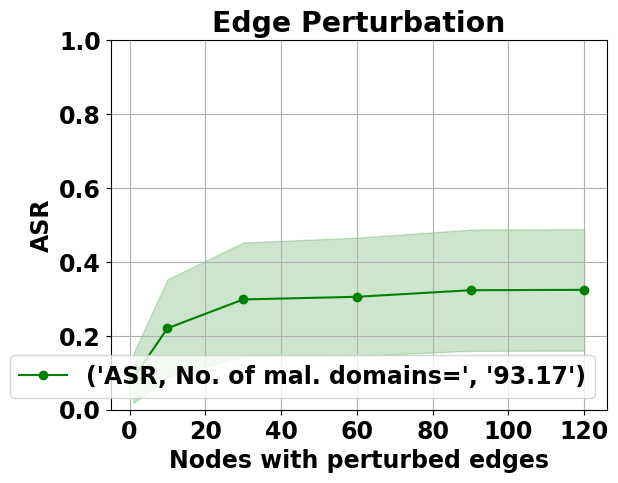

In [16]:
num_change_arr=val_nodes
if not os.path.exists('RESULTS_adj2_sampled_doms'):
    os.makedirs('RESULTS_adj2_sampled_doms')
plt.figure(facecolor='white')
plt.title("Edge Perturbation")
plt.xlabel("Nodes with perturbed edges") 
plt.ylabel("ASR") 

# plot the ASR:
m0, l0, u0=confid_measures(res_arr[:,0,:], Num)
plt.plot(val_nodes, m0,'-og', label=("ASR, No. of mal. domains=", '%.2f' % 93.17))
plt.fill_between(num_change_arr, l0, u0, color='green', alpha=0.2)
plt.ylim(0, 1)
plt.grid()
plt.legend(loc='lower right')
plt.grid()
plt.legend(loc='lower right')
plt.grid()
name='RESULTS_adj2_sampled_doms/asr_plot1_'+ str(Num)+'_trials_ras.png'
plt.savefig(name, dpi=150) 
name='RESULTS_adj2_sampled_doms/asr_plot1_'+ str(Num)+'_trials_ras.pdf'
plt.savefig(name, dpi=150) 
plt.show()


## Plot NFR

Shape of arr_tri: (30, 6)
Shape of arr_tri_mean: (6,)
Sorted mean: [ 2.86666667  7.23333333 12.3        12.4        13.6        13.66666667]
Sorted lower: [1.18890124 2.9484594  5.1001896  5.37030335 5.71082982 5.7221978 ]
Sorted upper: [ 4.54443209 11.51820727 19.42969665 19.4998104  21.4778022  21.62250351]


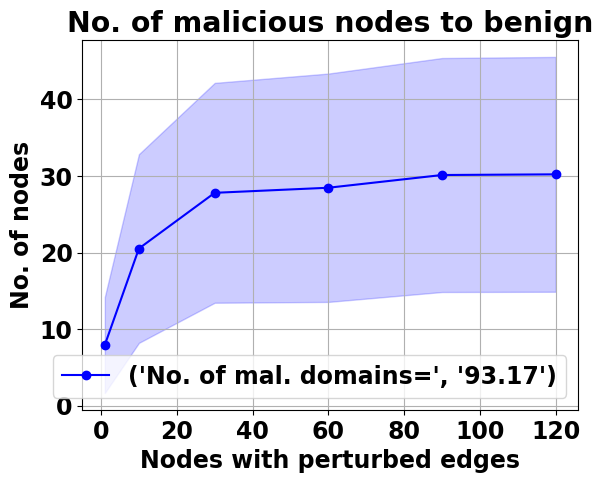

Shape of arr_tri: (30, 6)
Shape of arr_tri_mean: (6,)
Sorted mean: [ 2.86666667  7.23333333 12.3        12.4        13.6        13.66666667]
Sorted lower: [1.18890124 2.9484594  5.1001896  5.37030335 5.71082982 5.7221978 ]
Sorted upper: [ 4.54443209 11.51820727 19.42969665 19.4998104  21.4778022  21.62250351]


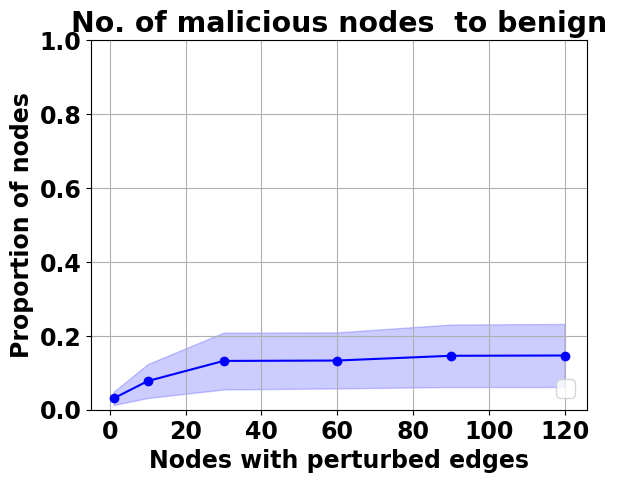

In [17]:
# NFR calculation using res_arr
m1, l1, u1 = confid_measures(res_arr[:, 1, :], Num)

plt.figure(facecolor='white')
plt.title("No. of malicious nodes to benign")
plt.xlabel("Nodes with perturbed edges")
plt.ylabel("No. of nodes")


plt.plot(val_nodes, m0*93.17, '-ob', label=("No. of mal. domains=", '%.2f' % 93.17))
plt.fill_between(val_nodes, l0*93.17, u0*93.17, color='blue', alpha=0.2)

plt.legend(loc='lower right')
plt.grid()

# Save plots
name = f'RESULTS_adj2_sampled_doms/nfr_plot_{Num}_trials_ras.png'
plt.savefig(name, dpi=150)
name = f'RESULTS_adj2_sampled_doms/nfr_plot_{Num}_trials_ras.pdf'
plt.savefig(name, dpi=150)

plt.show()

#with normalization
# Normalize NFR values
# Calculate NFR metrics using trial-level data
m1, l1, u1 = confid_measures(res_arr[:, 1, :], Num)

# Normalize NFR values
m1_normalized = m1 / 93.17  # Mean normalized by total malicious nodes
l1_normalized = l1 / 93.17  # Lower bound normalized
u1_normalized = u1 / 93.17  # Upper bound normalized

# Plot with normalized y-axis
plt.figure(facecolor='white')
plt.title("No. of malicious nodes  to benign")
plt.xlabel("Nodes with perturbed edges")
plt.ylabel("Proportion of nodes")

# Plot the normalized NFR with confidence intervals
plt.fill_between(val_nodes, l1_normalized, u1_normalized, color='blue', alpha=0.2)
plt.plot(val_nodes, m1_normalized, '-ob')

# Set the y-axis range to match the normalized scale
plt.ylim(0, 1)

# Add grid and legend
plt.legend(loc='lower right')
plt.grid()

# Save the plot
plt.savefig('RESULTS_adj2_sampled_doms/nfr_normalized_plot.png', dpi=150)
plt.savefig('RESULTS_adj2_sampled_doms/nfr_normalized_plot.pdf', dpi=150)

# Show the plot
plt.show()



## Plot ROC

arr1 shape: (6, 6)
Shape of arr_tri: (1, 6)
Shape of arr_tri_mean: (6,)
Sorted mean: [0.13965078 0.20221661 0.20345118 0.20637977 0.210578   0.21488152]
Sorted lower: [0.13965078 0.20221661 0.20345118 0.20637977 0.210578   0.21488152]
Sorted upper: [0.13965078 0.20221661 0.20345118 0.20637977 0.210578   0.21488152]
Computed FPR (m3): [0.13965078 0.20221661 0.20345118 0.20637977 0.210578   0.21488152]


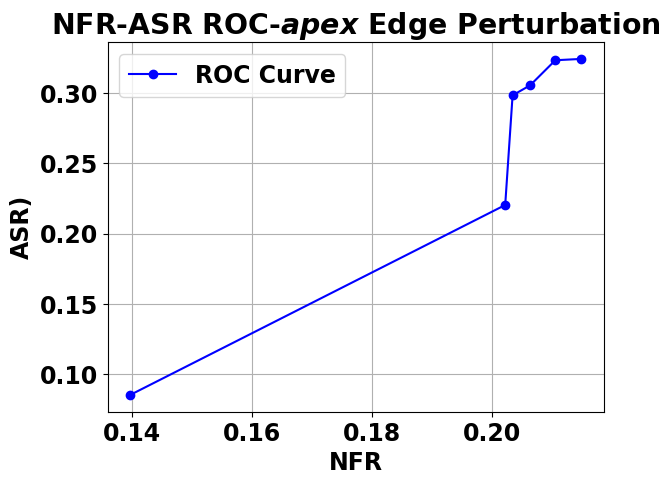

In [18]:
# Verify the shape of arr1
print("arr1 shape:", arr1.shape)

# Extract FPR values (3rd metric)
try:
    fpr_values = arr1[3, :]  # 3rd metric corresponds to FPR
    m3, l3, u3 = confid_measures(fpr_values.reshape(1, -1), 100)
    print("Computed FPR (m3):", m3)
except Exception as e:
    print("Error calculating m3 (FPR):", e)
    m3 = np.zeros_like(fpr_values)  # Fallback to zero array
    l3 = np.zeros_like(fpr_values)
    u3 = np.zeros_like(fpr_values)

# Assign TPR (ASR mean values) and FPR (FPR mean values)
tpr = m0  # True Positive Rate
fpr = m3  # False Positive Rate

# Plot the ROC Curve
plt.figure(facecolor='white')
plt.title("NFR-ASR ROC-$\it{apex}$ Edge Perturbation")
plt.xlabel("NFR") 
plt.ylabel("ASR)") 
plt.plot(fpr, tpr, '-ob', label="ROC Curve")  # Plot FPR vs. TPR
plt.legend()
plt.grid()

# Save the plot
name = 'RESULTS_adj2_sampled_doms/asr_plot3_' + str(Num) + '_ROC.png'
plt.savefig(name, dpi=150)
name = 'RESULTS_adj2_sampled_doms/asr_plot3_' + str(Num) + '_ROC.pdf'
plt.savefig(name, dpi=150)

# Show the plot
plt.show()
